In [3]:
from google.colab import files
uploaded = files.upload()


Saving cleaned_data_all.csv to cleaned_data_all.csv


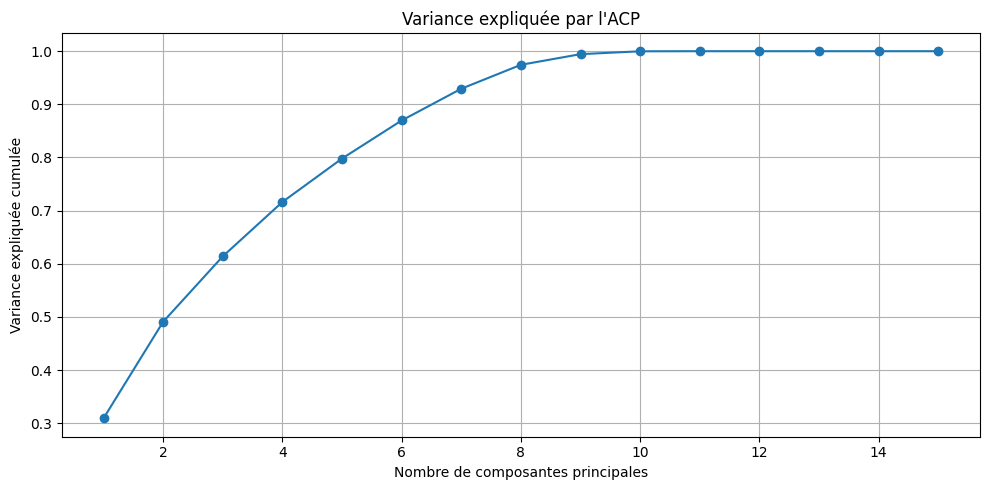

In [32]:
# 1. Importations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.utils import resample

# 2. Chargement des données
data_file_path = 'cleaned_data_all.csv'  # ← mets à jour le chemin si besoin
df = pd.read_csv(data_file_path, encoding='utf-8-sig')

### ACP sut le dataset non labelisé

# 1. Sélection des variables numériques (hors '_id')
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop('user_id')
X_numeric = df[numeric_cols].dropna()

 # 2. Centrage et réduction
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)

# 3. ACP
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# 4. Variance expliquée
explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

# 5. Visualisation de la variance expliquée cumulée
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.xlabel("Nombre de composantes principales")
plt.ylabel("Variance expliquée cumulée")
plt.title("Variance expliquée par l'ACP")
plt.grid(True)
plt.tight_layout()
plt.show()



In [33]:
# 1. Garder les 7 premières composantes
X_pca_7 = X_pca[:, :7]
df_pca_7 = pd.DataFrame(X_pca_7, columns=[f'PC{i+1}' for i in range(7)], index=X_numeric.index)

# 2. Colonnes exclues de l'ACP (non numériques)
excluded_cols = [col for col in df.columns if col not in numeric_cols and col != 'user_id']
categorical_cols = df.loc[X_numeric.index, excluded_cols].copy()  # ⬅ important : alignement

# 3. Encodage simple des colonnes catégorielles
from sklearn.preprocessing import LabelEncoder
for col in categorical_cols.select_dtypes(include=['object', 'bool']).columns:
    categorical_cols[col] = LabelEncoder().fit_transform(categorical_cols[col].astype(str))

# 4. Fusion PCA + variables catégorielles
dataset_init_final = pd.concat([df_pca_7, categorical_cols], axis=1)

# 5. Réintégration de l'identifiant
dataset_init_final['user_id'] = df.loc[X_numeric.index, 'user_id'].values

# 6. Vérification
print("✔️ Dimensions du dataset final :", dataset_init_final.shape)
dataset_init_final.head()


✔️ Dimensions du dataset final : (1832608, 8)


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,user_id
0,-0.398516,-0.055637,0.056957,0.179131,-0.114290,-0.524456,-0.034462,39084553
1,0.141513,-0.036801,-0.005316,-0.017944,-0.723320,0.032841,-0.062957,4872447178
2,-0.406596,-0.054985,-0.127945,-0.391358,-0.372220,-0.088945,0.000388,35628099
3,1.348105,-0.149545,0.006045,0.275845,1.230941,1.468292,0.065272,351196385
4,-0.503391,-0.055243,-0.117563,-0.374777,-0.358831,-0.092740,0.005125,1874916350


📊 Évaluation du Silhouette Score pour différentes valeurs de k :
  ➤ k = 2, Silhouette Score = 0.9780
  ➤ k = 3, Silhouette Score = 0.6453
  ➤ k = 4, Silhouette Score = 0.6383
  ➤ k = 5, Silhouette Score = 0.6389
  ➤ k = 6, Silhouette Score = 0.6485
  ➤ k = 7, Silhouette Score = 0.6504
  ➤ k = 8, Silhouette Score = 0.6432
  ➤ k = 9, Silhouette Score = 0.6483
  ➤ k = 10, Silhouette Score = 0.6504


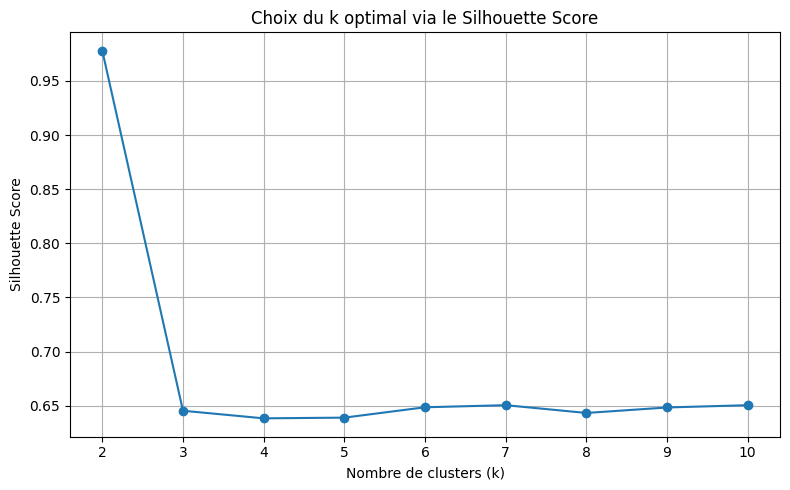


✅ Meilleur nombre de clusters selon Silhouette Score : k = 2


In [38]:
# 7. Recherche du k optimal via le Silhouette Score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.utils import resample

# Utilisation des 7 premières composantes déjà calculées dans X_pca_7
X_sample = resample(X_pca_7, n_samples=8000, random_state=42)

silhouette_scores = []
K_range = range(2, 11)

print(" Évaluation du Silhouette Score pour différentes valeurs de k :")
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_sample)
    score = silhouette_score(X_sample, labels)
    silhouette_scores.append(score)
    print(f"  ➤ k = {k}, Silhouette Score = {score:.4f}")

# 8. Visualisation du Silhouette Score
plt.figure(figsize=(8, 5))
plt.plot(K_range, silhouette_scores, marker='o')
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Choix du k optimal via le Silhouette Score")
plt.grid(True)
plt.tight_layout()
plt.show()

# 9. Sélection automatique du meilleur k
k_optimal = K_range[np.argmax(silhouette_scores)]
print(f"\n Meilleur nombre de clusters selon Silhouette Score : k = {k_optimal}")


In [40]:
from sklearn.cluster import MiniBatchKMeans

# 9. Clustering final sur 100 000 points à partir des 7 composantes principales
X_sample_100k = resample(X_pca_7, n_samples=100000, random_state=42)

kmeans_final = MiniBatchKMeans(n_clusters=k_optimal, random_state=42, batch_size=5000)
clusters = kmeans_final.fit_predict(X_sample_100k)


In [52]:
import plotly.express as px
import pandas as pd

# Assurez-vous que df_visu contient : PC1, PC2, cluster
fig = px.scatter(
    df_visu,
    x="PC1",
    y="PC2",
    color=df_visu["cluster"].astype(str),  # Pour forcer une légende propre
    title=f"Clustering interactif via PCA (k = {k_optimal})",
    opacity=0.5,
    height=600,
    width=900
)

# Optionnel : ajuster le zoom initial
fig.update_layout(
    xaxis_range=[-1, 25],
    yaxis_range=[-1, 25],
    legend_title="Cluster"
)

# Afficher
fig.show()
